**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Data

Info about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA

Read in the data set "Miles_Traveled.csv" from the Data folder. Figure out how to set the date to a datetime index columns

In [2]:
# CODE HERE

In [3]:
df = pd.read_csv('../Data/Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [4]:
df.head()

TRFVOLUSM227NFWA
DATE                        
1970-01-01           80173.0
1970-02-01           77442.0
1970-03-01           90223.0
1970-04-01           89956.0
1970-05-01           97972.0

**Task: Change the column names to Value**

In [5]:
df.columns = ['Value']

**TASK: Plot out the time series**

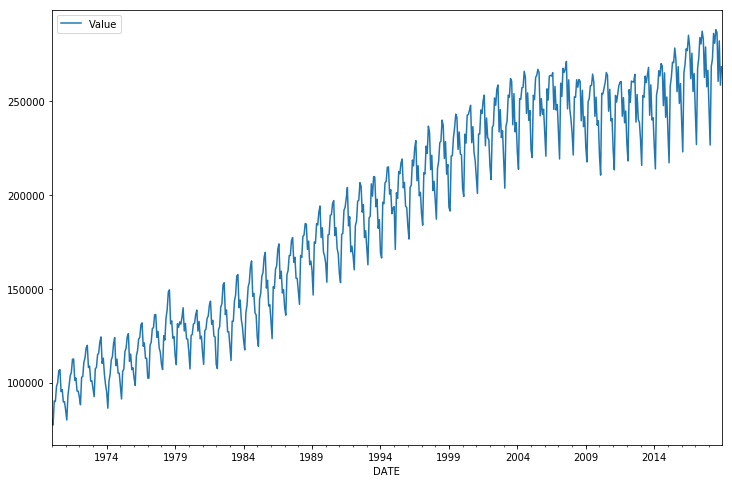

In [6]:
df.plot(figsize=(12,8))

**TASK: Perform a Seasonal Decomposition on the model and plot out the ETS components**

In [7]:
# CODE HERE

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

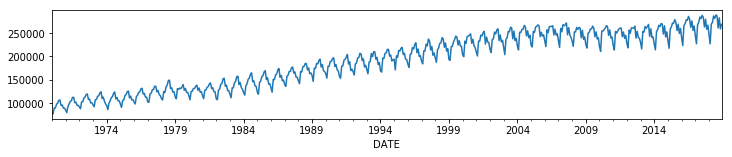

In [9]:
results = seasonal_decompose(df['Value'])
results.observed.plot(figsize=(12,2))

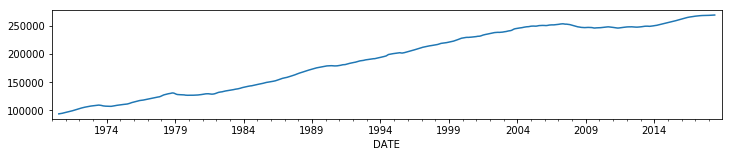

In [10]:
results.trend.plot(figsize=(12,2))

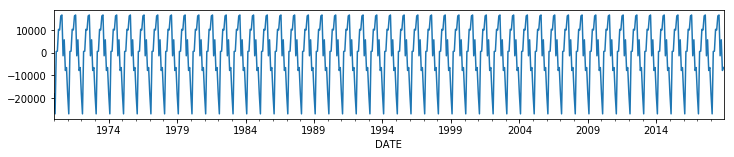

In [11]:
results.seasonal.plot(figsize=(12,2))

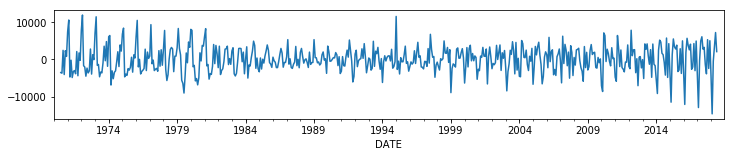

In [12]:
results.resid.plot(figsize=(12,2))

## Train Test Split

**TASK: Figure out the length of the data set**

In [13]:
len(df)

588

In [14]:
train_len = len(df)-12

**TASK: Split the data into a train/test split where the test set is the last 12 months of data.**

In [15]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [16]:
len(test)

12

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [17]:
# CODE HERE

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [21]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The n_input is up to you, but at a minimum it should be at least 12.**

In [22]:
#CODE HERE

In [23]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [24]:
n_input = 24
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTAM units you want and a final Dense Layer.**

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [26]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


**TASK: Fit the model to the generator (it should be a lot of epochs, but do as many as you have the patience for! :)**

In [28]:
# CODE HERE

In [29]:
# fit model
model.fit_generator(generator,epochs=30)

Epoch 1/30
552/552 [==============================] - 18s 33ms/step - loss: 0.0139
Epoch 2/30
552/552 [==============================] - 17s 30ms/step - loss: 0.0070
Epoch 3/30
552/552 [==============================] - 16s 30ms/step - loss: 0.0056
Epoch 4/30
552/552 [==============================] - 16s 29ms/step - loss: 0.0050
Epoch 5/30
552/552 [==============================] - 17s 30ms/step - loss: 0.0036
Epoch 6/30
552/552 [==============================] - 16s 30ms/step - loss: 0.0025
Epoch 7/30
552/552 [==============================] - 16s 30ms/step - loss: 0.0025
Epoch 8/30
552/552 [==============================] - 17s 30ms/step - loss: 0.0018
Epoch 9/30
552/552 [==============================] - 18s 32ms/step - loss: 0.0016
Epoch 10/30
552/552 [==============================] - 19s 34ms/step - loss: 0.0017
Epoch 11/30
552/552 [==============================] - 18s 33ms/step - loss: 0.0016
Epoch 12/30
552/552 [==============================] - 18s 33ms/step - loss: 0.0013
E

**TASK: Plot the history of the loss that occured during training.**

In [30]:
# CODE HERE

In [31]:
model.history.history.keys()

dict_keys(['loss'])

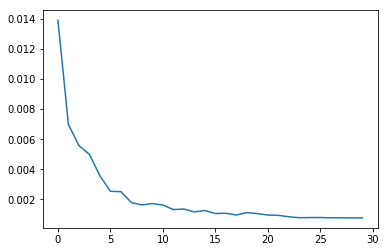

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluate on Test Data

**TASK: Based on your test data and input size, create an appropriate;y sized "first evaluation batch" like we did in the lecture.**

In [33]:
first_eval_batch = scaled_train[-12:]

In [34]:
first_eval_batch

array([[0.79630397],
       [0.71226435],
       [0.90477416],
       [0.93121043],
       [0.98386382],
       [0.96757519],
       [1.        ],
       [0.9801859 ],
       [0.8824684 ],
       [0.95995255],
       [0.85883345],
       [0.90086755]])

In [35]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

**TASK: Generate predictions into the same time stamps as the test set**

In [36]:
# CODE HERE

In [37]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

**TASK: Inverse Transform your new forecasted predictions.**

In [38]:
#CODE HERE

In [39]:
true_predictions = scaler.inverse_transform(test_predictions)

In [40]:
true_predictions

array([[244790.4583751 ],
       [233844.90710074],
       [270457.81608635],
       [272201.29687929],
       [279289.6588499 ],
       [279346.60926121],
       [286210.98546427],
       [281885.08126384],
       [268614.50942963],
       [275487.78100669],
       [258639.72996229],
       [262481.15531212]])

**TASK: Create a new dataframe that has both the original test values and your predictions for them.**

In [41]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Marcial\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
test

Value    Predictions
DATE                               
2018-01-01  245695.0  244790.458375
2018-02-01  226660.0  233844.907101
2018-03-01  268480.0  270457.816086
2018-04-01  272475.0  272201.296879
2018-05-01  286164.0  279289.658850
2018-06-01  280877.0  279346.609261
2018-07-01  288145.0  286210.985464
2018-08-01  286608.0  281885.081264
2018-09-01  260595.0  268614.509430
2018-10-01  282174.0  275487.781007
2018-11-01  258590.0  258639.729962
2018-12-01  268413.0  262481.155312

**TASK: Plot out the test set against your own predicted values.**

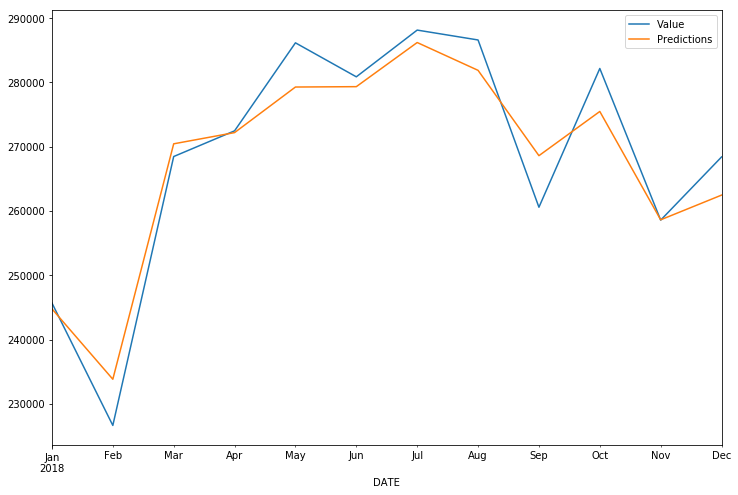

In [43]:
test.plot(figsize=(12,8))

# Saving Models

**TASK: Optional, Save your model!**

In [44]:
model.save('solutions_model.h5')